# VGG-19: CIFAR-10 dataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"currently available device: {device}")

currently available device: cuda


In [ ]:
# Hyper-parameters-
num_epochs = 200
batch_size = 128
learning_rate = 0.01

In [ ]:
# Define transformations for training and test sets-
transform_train = transforms.Compose(
    [
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

transform_test = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

In [ ]:
'''
# Dataset has PILImage images of range [0, 1]. We transform them to Tensors
# of normalized range [-1, 1]
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]
        )
'''

In [ ]:
# os.chdir("/home/arjun/Documents/Programs/Python_Codes/PyTorch_Resources/Good_Codes/")

In [ ]:
# Load dataset-
train_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = True,
        download = True, transform = transform_train
        )

test_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = False,
        download = True, transform = transform_test
        )


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(f"len(train_dataset) = {len(train_dataset)} & len(test_dataset) = {len(test_dataset)}")

len(train_dataset) = 50000 & len(test_dataset) = 10000


In [ ]:
# Create training and testing loaders-
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [ ]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 391 & len(test_loader) = 79


In [ ]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(390.625, 78.125)

In [ ]:
# Get some random training images-
# some_img = iter(train_loader)
# images, labels = some_img.next()
images, labels = next(iter(train_loader))

# You get 32 images due to our specified batch size-
print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")

images.shape: torch.Size([128, 3, 32, 32]) & labels.shape: torch.Size([128])


In [ ]:
class VGGBlock(nn.Module):
    '''
    VGG-19 block within a VGG CNN model
    '''
    def __init__(self, input_channels, num_channels, padding_size = 1,
                 stride_size = 1, use_extra_conv = False):
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = input_channels, out_channels = num_channels,
            kernel_size = 3, padding = padding_size,
            stride = stride_size, bias = False
        )
        
        self.conv2 = nn.Conv2d(
            in_channels = num_channels, out_channels = num_channels,
            kernel_size = 3, padding = padding_size,
            stride = stride_size, bias = False
        )
        
        if use_extra_conv:
            self.conv3 = nn.Conv2d(
                in_channels = num_channels, out_channels = num_channels,
                kernel_size = 3, padding = padding_size,
                stride = stride_size, bias = False
            )
            
            self.conv4 = nn.Conv2d(
                in_channels = num_channels, out_channels = num_channels,
                kernel_size = 3, padding = padding_size,
                stride = stride_size, bias = False
            )
        else:
            self.conv3 = False
            self.conv4 = False
        
        self.pool = nn.MaxPool2d(
            kernel_size = 2, stride = 2)
            # padding = 1)
        
        self.bn1 = nn.BatchNorm2d(num_features = num_channels)
        self.bn2 = nn.BatchNorm2d(num_features = num_channels)
        self.bn3 = nn.BatchNorm2d(num_features = num_channels)
        self.bn4 = nn.BatchNorm2d(num_features = num_channels)
        
        self.initialize_weights()
    
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        
        if self.conv3 and self.conv4:
            Y = F.relu(self.bn3(self.conv3(Y)))
            Y = F.relu(self.bn4(self.conv4(Y)))
            Y = self.pool(Y)
        else:
            Y = self.pool(Y)
        
        return Y
    
    
    def shape_computation(self, X):
        Y = self.bn1(self.conv1(X))
        print(f"self.bn(conv1(X)).shape: {Y.shape}")
        
        Y = self.bn2(self.conv2(Y))
        print(f"self.bn(conv2(Y)).shape: {Y.shape}")
        
        if self.conv3 and self.conv4:
            Y = self.bn3(self.conv3(Y))
            print(f"self.bn(conv3(Y)).shape: {Y.shape}")
            
            Y = self.bn4(self.conv4(Y))
            print(f"self.bn(conv4(Y)).shape: {Y.shape}")
            
            Y = self.pool(Y)
            print(f"self.pool(Y).shape: {Y.shape}")
        else:
            Y = self.pool(Y)
            print(f"self.pool(Y).shape: {Y.shape}")
        

    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

        

In [ ]:
# Sanity check-
b1 = VGGBlock(input_channels = 3, num_channels = 64)

In [ ]:
# Compute dimensions of images for each layer within the VGG block-
b1.shape_computation(images)

self.bn(conv1(X)).shape: torch.Size([128, 64, 32, 32])
self.bn(conv2(Y)).shape: torch.Size([128, 64, 32, 32])
self.pool(Y).shape: torch.Size([128, 64, 16, 16])


In [ ]:
Y = b1(images)

In [ ]:
Y.shape

torch.Size([128, 64, 16, 16])

In [ ]:
b2 = VGGBlock(input_channels = 64, num_channels = 128)

In [ ]:
Y = b2(Y)

In [ ]:
Y.shape

torch.Size([128, 128, 8, 8])

In [ ]:
b2.shape_computation(torch.rand(128, 64, 16, 16))

self.bn(conv1(X)).shape: torch.Size([128, 128, 16, 16])
self.bn(conv2(Y)).shape: torch.Size([128, 128, 16, 16])
self.pool(Y).shape: torch.Size([128, 128, 8, 8])


In [ ]:
b3 = VGGBlock(input_channels = 128, num_channels = 256, use_extra_conv = True)

In [ ]:
Y = b3(Y)

In [ ]:
Y.shape

torch.Size([128, 256, 4, 4])

In [ ]:
b3.shape_computation(torch.rand(128, 128, 8, 8))

self.bn(conv1(X)).shape: torch.Size([128, 256, 8, 8])
self.bn(conv2(Y)).shape: torch.Size([128, 256, 8, 8])
self.bn(conv3(Y)).shape: torch.Size([128, 256, 8, 8])
self.bn(conv4(Y)).shape: torch.Size([128, 256, 8, 8])
self.pool(Y).shape: torch.Size([128, 256, 4, 4])


In [ ]:
b4 = VGGBlock(input_channels = 256, num_channels = 512, use_extra_conv = True)

In [ ]:
Y = b4(Y)

In [ ]:
Y.shape

torch.Size([128, 512, 2, 2])

In [ ]:
b4.shape_computation(torch.rand(128, 256, 4, 4))

self.bn(conv1(X)).shape: torch.Size([128, 512, 4, 4])
self.bn(conv2(Y)).shape: torch.Size([128, 512, 4, 4])
self.bn(conv3(Y)).shape: torch.Size([128, 512, 4, 4])
self.bn(conv4(Y)).shape: torch.Size([128, 512, 4, 4])
self.pool(Y).shape: torch.Size([128, 512, 2, 2])


In [ ]:
b5 = VGGBlock(input_channels = 512, num_channels = 512, use_extra_conv = True)

In [ ]:
Y = b5(Y)

In [ ]:
Y.shape

torch.Size([128, 512, 1, 1])

In [ ]:
b5.shape_computation(torch.rand(128, 512, 2, 2))

self.bn(conv1(X)).shape: torch.Size([128, 512, 2, 2])
self.bn(conv2(Y)).shape: torch.Size([128, 512, 2, 2])
self.bn(conv3(Y)).shape: torch.Size([128, 512, 2, 2])
self.bn(conv4(Y)).shape: torch.Size([128, 512, 2, 2])
self.pool(Y).shape: torch.Size([128, 512, 1, 1])


In [ ]:
pool_layer = nn.MaxPool2d(kernel_size = 1, stride = 1)

In [ ]:
Y = pool_layer(Y)

In [ ]:
Y.shape

torch.Size([128, 512, 1, 1])

In [ ]:
# Initialize VGG-19 model-
model = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.MaxPool2d(kernel_size = 1, stride = 1),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 256),
    nn.Linear(in_features = 256, out_features = 10))

In [ ]:
# Load initialization weights-
# model.load_state_dict(torch.load("/content/VGG19_kaiming_uniform_random_weights.pth"))

In [ ]:
# Place model on GPU (if available)-
model.to(device)

Sequential(
  (0): VGGBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): VGGBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentu

In [ ]:
# Save random initial weights-
torch.save(model.state_dict(), '/content/VGG19_kaiming_uniform_random_weights.pth')

In [ ]:
# model(images).shape
# torch.Size([128, 10])

In [ ]:
# Sanity check- make predictions using the define model-
model(images.to(device)).shape  # don't forget to place images to GPU device

torch.Size([128, 10])

In [ ]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

In [ ]:
print(f"Total number of parameters in VGG-19 CNN = {tot_params}")

# Total number of parameters in VGG-19 CNN = 20164554
# Total number of parameters in VGG-16 CNN = 14853194

Total number of parameters in VGG-19 CNN = 20164554


In [ ]:
# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")

In [ ]:
X = images
X.shape

torch.Size([128, 3, 32, 32])

In [ ]:
X.to(device) # place on device

In [ ]:
'''
Before training VGG-19, let us observe how the input shape changes across
different modules in ResNet.
As in all the previous architectures, the resolution decreases while the number
of channels increases up until the point where a global average pooling layer
aggregates all features.
'''
for layer in model:
    # X.to(device)
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

VGGBlock output shape:	 torch.Size([128, 64, 16, 16])
VGGBlock output shape:	 torch.Size([128, 128, 8, 8])
VGGBlock output shape:	 torch.Size([128, 256, 4, 4])
VGGBlock output shape:	 torch.Size([128, 512, 2, 2])
VGGBlock output shape:	 torch.Size([128, 512, 1, 1])
MaxPool2d output shape:	 torch.Size([128, 512, 1, 1])
Flatten output shape:	 torch.Size([128, 512])
Linear output shape:	 torch.Size([128, 256])
Linear output shape:	 torch.Size([128, 10])


In [ ]:
model(images.to(device)).shape

torch.Size([128, 10])

### Train VGG-19 CNN model:

In [ ]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 5

In [ ]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 100
loc_patience = 0

In [ ]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [ ]:
# Python3 lists to store model training metrics-
training_acc = []
validation_acc = []
training_loss = []
validation_loss = []

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0.0
    running_loss_val = 0.0
    
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    
    
    for batch, (images, labels) in enumerate(train_loader):
        # Attempt to push to GPU if available
        images = images.to(device)
        labels = labels.to(device)

        model.train()

        # Forward pass-
        outputs = model(images)

        # Compute loss-
        J = loss(outputs, labels)

        # Backward pass-
        optimizer.zero_grad()   # empty accumulated gradients

        J.backward()    # does backprop

        # Updates parameters-
        optimizer.step()
        
        # Compute model's performance statistics-
        running_loss += J.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)

        '''
        # Print information every 100 steps-
        if (batch + 1) % 100 == 0:
            print(f"epoch {epoch + 1}/{num_epochs}, step {batch + 1}/{num_training_steps}, loss = {J.item():.4f}")
        '''

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    # print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%\n")

    total = 0
    correct = 0
    
    with torch.no_grad():
        for images, labels in test_loader:

            # Place features (images) and targets (labels) to GPU-
            images = images.to(device)
            labels = labels.to(device)
            # print(f"images.shape = {images.shape}, labels.shape = {labels.shape}")

            # Set model to evaluation mode-
            model.eval()
    
            # Make predictions using trained model-
            outputs = model(images)
            _, y_pred = torch.max(outputs, 1)

            # Compute validation loss-
            J_val = loss(outputs, labels)

            running_loss_val += J_val.item() * labels.size(0)
    
            # Total number of labels-
            total += labels.size(0)

            # Total number of correct predictions-
            correct += (y_pred == labels).sum()

    epoch_val_loss = running_loss_val / len(test_dataset)
    val_acc = 100 * (correct / total)
    print(f"\nepoch: {epoch + 1} training loss = {epoch_loss:.4f}, training accuracy = {epoch_acc * 100:.2f}%, val_loss = {epoch_val_loss:.4f} & val_accuracy = {val_acc:.2f}%\n")

    # Code for manual Early Stopping:
    # if np.abs(epoch_val_loss < best_val_loss) >= minimum_delta:
    if (epoch_val_loss < best_val_loss) and np.abs(epoch_val_loss - best_val_loss) >= minimum_delta:
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = epoch_val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0

        print(f"\nSaving model with lowest val_loss = {epoch_val_loss:.4f}")
        
        # Save trained model with lowest validation loss-
        # torch.save(model.state_dict, f"LeNet-300-100_Trained_{val_acc}.pth")
        torch.save(model.state_dict(), "/content/VGG19_CIFAR10_Trained.pth")

        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement


    training_acc.append(epoch_acc * 100)
    validation_acc.append(val_acc)
    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    


epoch: 1 training loss = 1.4903, training accuracy = 44.93%, val_loss = 1.1879 & val_accuracy = 57.94%


Saving model with lowest val_loss = 1.1879

epoch: 2 training loss = 1.0245, training accuracy = 63.26%, val_loss = 0.9425 & val_accuracy = 66.34%


Saving model with lowest val_loss = 0.9425

epoch: 3 training loss = 0.8164, training accuracy = 71.50%, val_loss = 0.7459 & val_accuracy = 74.17%


Saving model with lowest val_loss = 0.7459

epoch: 4 training loss = 0.6970, training accuracy = 75.77%, val_loss = 0.6678 & val_accuracy = 77.46%


Saving model with lowest val_loss = 0.6678

epoch: 5 training loss = 0.6064, training accuracy = 78.71%, val_loss = 0.6813 & val_accuracy = 77.23%


epoch: 6 training loss = 0.5511, training accuracy = 81.05%, val_loss = 0.6355 & val_accuracy = 78.51%


Saving model with lowest val_loss = 0.6355

epoch: 7 training loss = 0.5069, training accuracy = 82.52%, val_loss = 0.6749 & val_accuracy = 77.80%


epoch: 8 training loss = 0.4579, training ac

In [ ]:
print(f"\nVGG-19 CNN training on CIFAR-10 is complete\n")


VGG-19 CNN training on CIFAR-10 is complete



In [ ]:
# Initialize ResNet-34 trained model-
trained_model = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.MaxPool2d(kernel_size = 1, stride = 1),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 256),
    nn.Linear(in_features = 256, out_features = 10))

In [ ]:
trained_model.load_state_dict(torch.load("/content/VGG19_CIFAR10_Trained.pth"))

<All keys matched successfully>

In [ ]:
trained_model.to(device)

Sequential(
  (0): VGGBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): VGGBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentu

In [ ]:
# Variables for computing model metrics-
total = 0
correct = 0

In [ ]:
# Evaluate trained CNN model. We don't want these operations to be tracked in
# the computational graph. Hence wrap these operations in-
with torch.no_grad():
    for images, labels in test_loader:

        # Place features (images) and targets (labels) to GPU-
        images = images.to(device)
        labels = labels.to(device)
        # print(f"images.shape = {images.shape}, labels.shape = {labels.shape}")

        # Set model to evaluation mode-
        trained_model.eval()

        # Make predictions using trained model-
        outputs = model(images)
        _, y_pred = torch.max(outputs, 1)
    
        # Total number of labels-
        total += labels.size(0)

        # Total number of correct predictions-
        correct += (y_pred == labels).sum()

    val_acc = 100 * (correct / total)
    print(f"VGG-19 trained CNN's validation metrics on CIFAR-10 are:")
    print(f"accuracy = {val_acc:.2f}%, # of correct labels = {correct} & total # of labels = {total}")


VGG-19 trained CNN's validation metrics on CIFAR-10 are:
accuracy = 85.75%, # of correct labels = 17150 & total # of labels = 20000


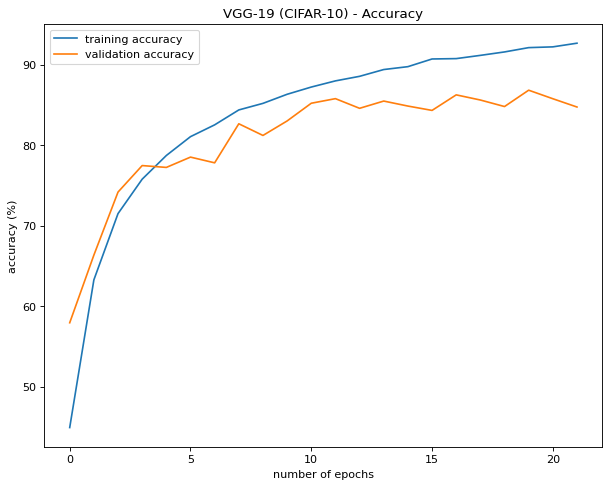

In [ ]:
# Visualize training metrics-
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(np.asarray(training_acc), label = 'training accuracy')
plt.plot(np.asarray(validation_acc), label = 'validation accuracy')

plt.title("VGG-19 (CIFAR-10) - Accuracy")
plt.xlabel("number of epochs")
plt.ylabel("accuracy (%)")
# plt.xlim((0, 20))
plt.legend(loc = 'best')
plt.show()


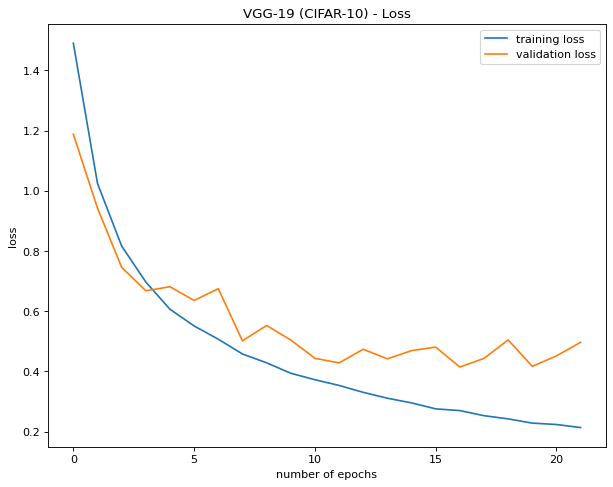

In [ ]:
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(np.asarray(training_loss), label = 'training loss')
plt.plot(np.asarray(validation_loss), label = 'validation loss')

plt.title("VGG-19 (CIFAR-10) - Loss")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.show()